In [7]:
%load_ext autoreload
%autoreload all

# from multiprocessing.pool import ThreadPool as Pool
from multiprocessing.pool import Pool
from multiprocessing import freeze_support

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from snn_dpe.tools.data import Mackey_Glass, util
from snn_dpe.tools.network import create_network
from snn_dpe.tools.plotting import *
from snn_dpe.tools.train.timeseries import train_TS

freeze_support()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
MG_data_tr = Mackey_Glass.read_MG_data('../../Data/MarkusThill-MGAB-60f6b17/1.csv', normalize=True)
MG_data_te = Mackey_Glass.read_MG_data('../../Data/MarkusThill-MGAB-60f6b17/2.csv', normalize=True)

# slice up MG into input, output pairs
input_window_size = 10
output_window_size = 1

# max here is 10,000 since that's the length of the csv
n_tr_data = 2000
n_te_data = 2000

MG_inputs_tr, MG_outputs_tr = util.generate_io_pairs(MG_data_tr[:n_tr_data], input_window_size, output_window_size)
MG_inputs_te, MG_outputs_te = util.generate_io_pairs(MG_data_te[:n_te_data], input_window_size, output_window_size)


def run_test(args):
    tr_mses = []
    te_mses = []

    np.random.seed()

    noise_axis = np.linspace(0, 0.1, num=40)

    for n in noise_axis:

        # create a test network
        n_neurons = 30
        synapse_density = 0.1
        n_input = 12 #how many neurons will receive potentiation adjustments related to MG
        n_synapses = int((n_neurons**2)*synapse_density)

        # dpe noise
        write_noise = 0
        # synapse parameters
        drift = 0
        synapse_noise = 0

        # training parameters
        n_epochs = 5
        post_sample_reset = True #also applies to testing
        reset_synapses = True #also applies to testing
        post_epoch_reset = False
        MG_inputs_te_noise = MG_inputs_te + np.random.normal(0, n)

        neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.25), weight_factor = 1, std_dev=synapse_noise, drift = drift)
        # train
        training_mses, testing_mses, _, _ = train_TS(n_epochs, MG_inputs_tr, MG_outputs_tr, neurons, n_input, silent=True, TS_inputs_te=MG_inputs_te_noise, TS_outputs_te=MG_outputs_te, relative=True, write_noise_std=write_noise, post_sample_reset=post_sample_reset, reset_synapses=reset_synapses, post_epoch_reset=post_epoch_reset)
        
        # save the final mses of the last epoch
        tr_mses.append(training_mses[-1])
        te_mses.append(testing_mses[-1])

    return tr_mses, te_mses, noise_axis


n_tests = 10
n_threads = 12
with Pool(processes=n_threads) as p:
    results = list(tqdm(p.imap(run_test, range(n_tests)), total=n_tests))
    


  0%|          | 0/10 [00:00<?, ?it/s]

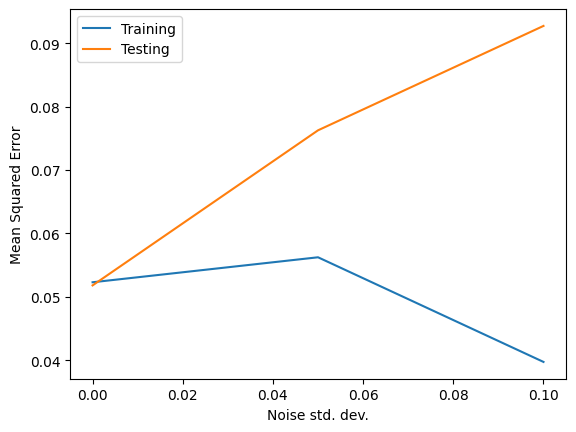

In [33]:
(tr_mses, te_mses, noise_axis) = np.mean(results, axis=0)


plt.plot(noise_axis, tr_mses, label='Training')
plt.plot(noise_axis, te_mses, label='Testing')
plt.legend()
plt.xlabel('Noise std. dev.')
plt.ylabel('Mean Squared Error')
# plt.ylim(0, 100)
# plt.yscale('log')
plt.show()

In [13]:
import csv

wtr = csv.writer(open('MG_noise_vs_MSE_dataset_2.csv', 'w'), delimiter=',', lineterminator='\n')

for data in zip(tr_mses, te_mses, noise_axis):
    wtr.writerow(list(data))

In [26]:
results[0]

array([[0.03569077, 0.04504214, 0.04846821, 0.05084323, 0.04514203,
        0.04346519, 0.03535075, 0.04442164, 0.03767223, 0.03802806,
        0.04409862, 0.04450688, 0.0520828 , 0.04229806, 0.04850902,
        0.0418753 , 0.05235652, 0.03875775, 0.04596029, 0.03819355,
        0.03906865, 0.04808275, 0.04191572, 0.04674182, 0.04816363,
        0.04311026, 0.04776751, 0.04427909, 0.04296632, 0.04715466,
        0.0462346 , 0.04665368, 0.034642  , 0.04266338, 0.04867882,
        0.03779191, 0.0401991 , 0.05707378, 0.04244624, 0.04397057],
       [0.03505587, 0.04506079, 0.05185148, 0.04983831, 0.04379766,
        0.04526664, 0.03741412, 0.04596549, 0.04075462, 0.04656697,
        0.04706307, 0.06058318, 0.0543101 , 0.04826512, 0.05331664,
        0.04182388, 0.05922693, 0.08029622, 0.04777588, 0.0419494 ,
        0.06574169, 0.04977439, 0.04326459, 0.055216  , 0.05443311,
        0.04374007, 0.0481826 , 0.06892779, 0.05276536, 0.07849933,
        0.04966124, 0.04485716, 0.04610953, 0.1

(2, 3)
[0.05808694 0.05440988]


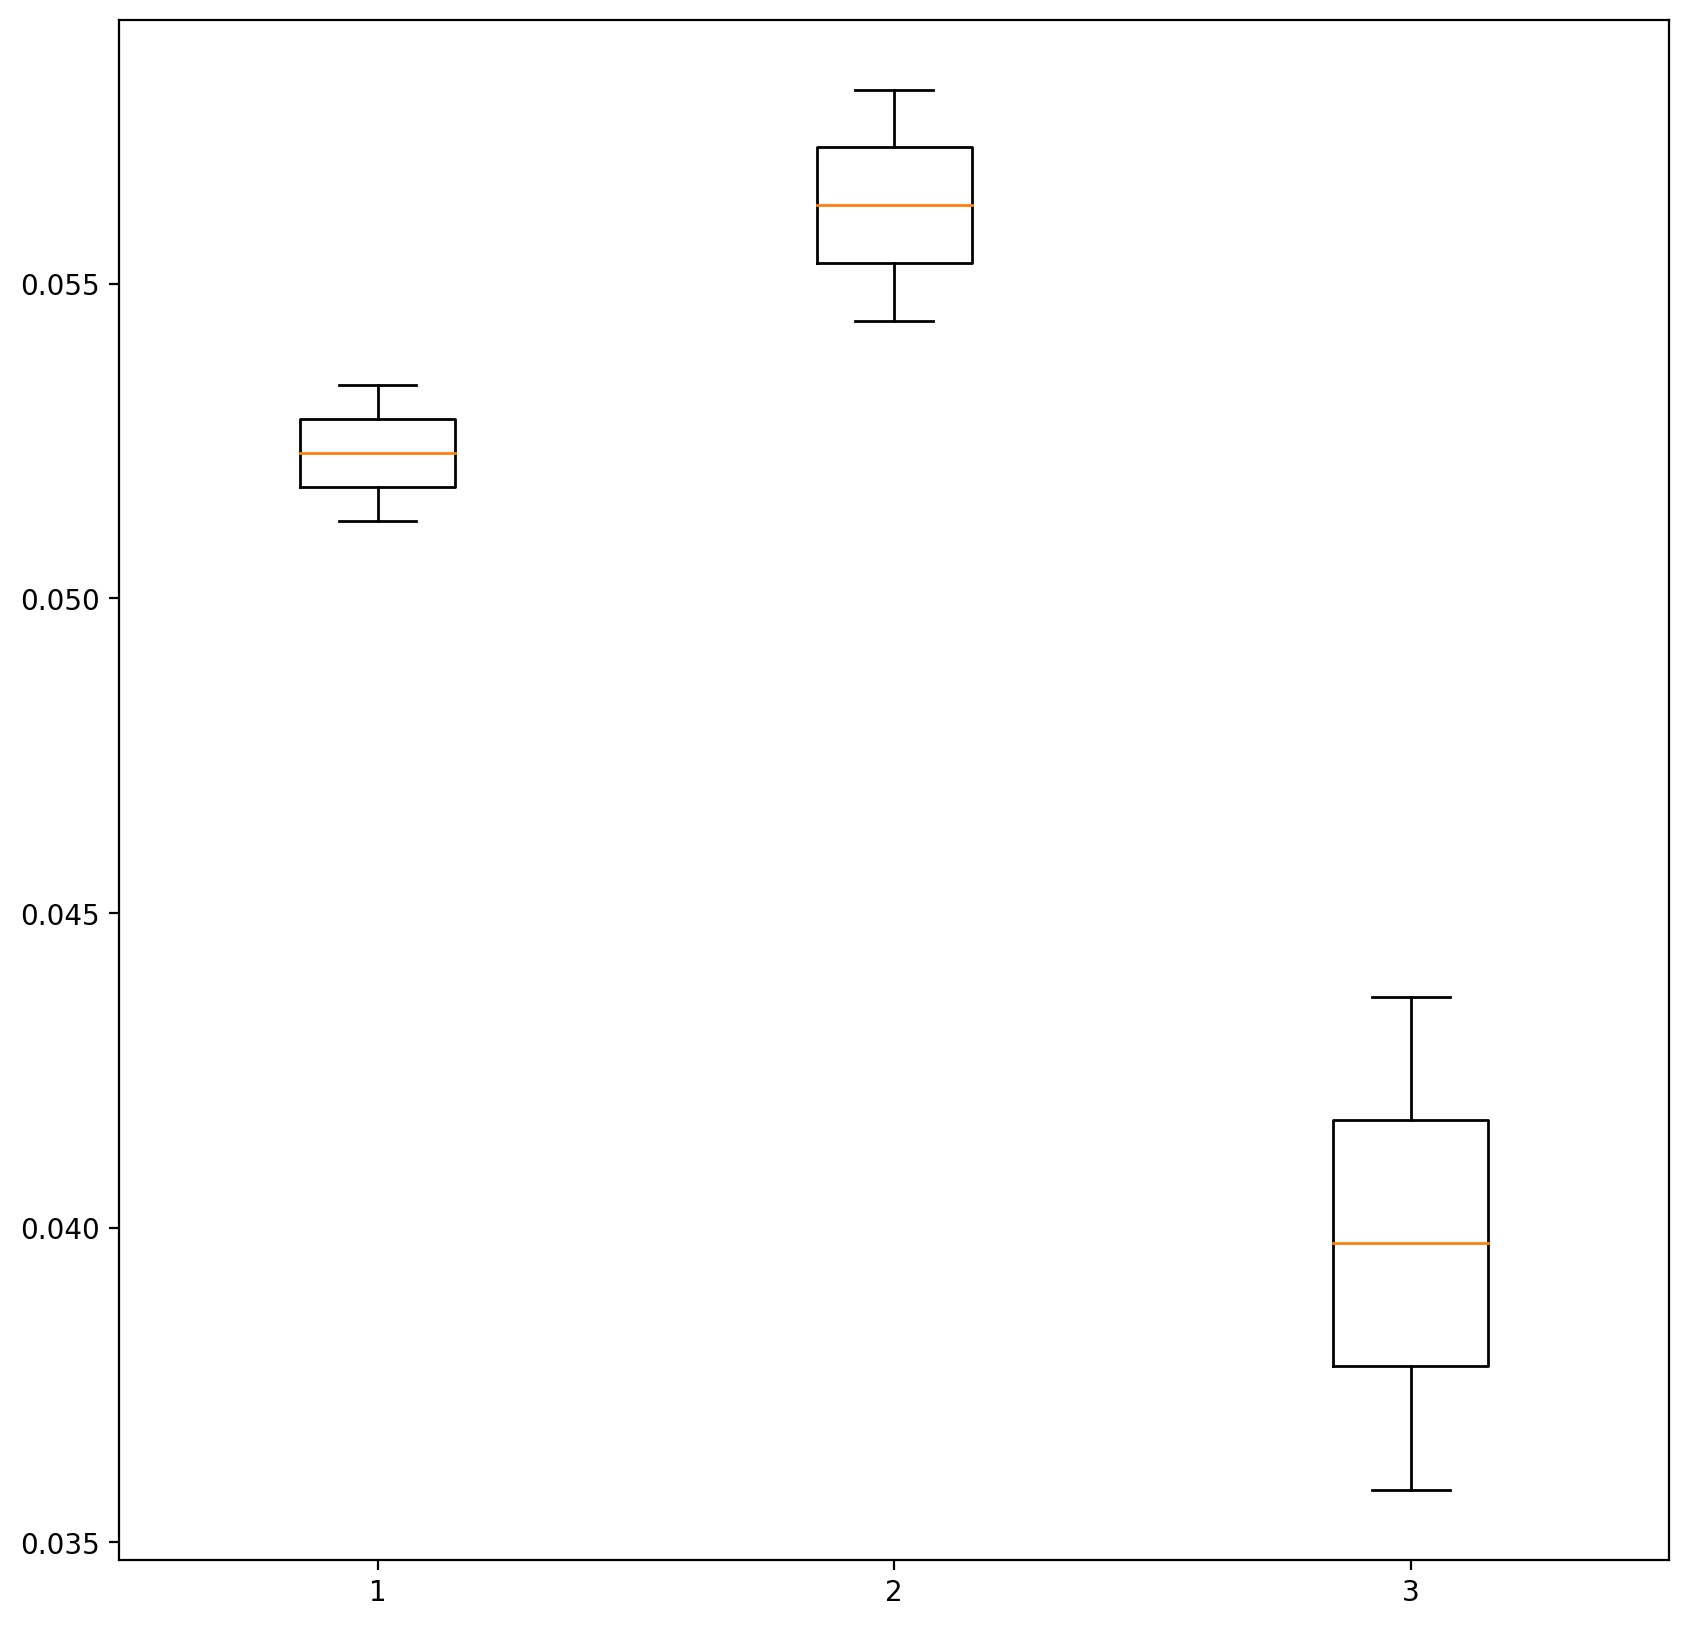

In [34]:
all_tr_mses = []

for r in results:
    all_tr_mses.append([])
    for d in r[0]:
        all_tr_mses[-1].append(d)
fig = plt.subplots(figsize=(10,10), dpi=200)
all_tr_mses = np.asarray(all_tr_mses)
print(all_tr_mses.shape)
print(all_tr_mses[:,1])
plt.boxplot(all_tr_mses)
plt.show()